# 计算机视觉解释

`vision.interpret`是通过继承它来为不同的视觉任务实现自定义解释类的模块。

---

## class SegmentationInterpretation
`SegmentationInterpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>) :: Interpretation`

分割模型的解释方法。

**top_losses**

`top_losses(sizes:Tuple, k:int=None, largest=True)`

减少压平损失，为每个图像提供单一损失值

**_interp_show**

`_interp_show(ims:ImageSegment, classes:Collection[T_co]=None, sz:int=20, cmap='tab20', title_suffix:str=None)`

显示带有颜色映射标签的ImageSegment

**show_xyz**

`show_xyz(i, classes:list=None, sz=10)`

来自带有颜色映射的self.ds的show（image，true和pred），可选择只有绘图

**_generate_confusion**

`_generate_confusion()`

平均和每图像混淆：给定真实标签的像素的交集，真实标签总和为1

**_plot_intersect_cm**

`_plot_intersect_cm(cm, title='Intersection with Predict given True')`

绘制混淆矩阵：_generate_confusion生成的self.mean_cm或self.single_img_cm

让我们展示一旦我们训练分割模型，如何使用SegmentationInterpretation。

## 训练

In [2]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *
from fastai.vision.interpret import *

In [4]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

In [5]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [6]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

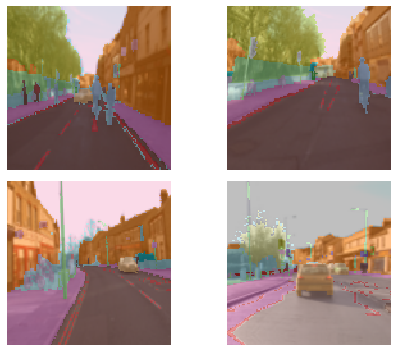

In [8]:
data.show_batch(rows=2, figsize=(7,5))

In [ ]:
learn = unet_learner(data, models.resnet18)
learn.fit_one_cycle(3,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,11.338507,2.603763,01:13
1,7.344568,2.317760,01:05


警告：对于这个表现不佳的模型，以下结果将没有多大意义，但功能将很容易解释

## 解释

In [8]:
interp = SegmentationInterpretation.from_learner(learn)
interp

由于使用了CrossEntropyLoss()的FlattenedLoss，我们重新整形然后采用每个图像的像素损失的平均值。 为了做到这一点，我们需要传递`sizes:tuple`到top_losses()

In [9]:
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

接下来，我们可以生成类似于我们通常用于分类的混淆矩阵。 生成两个混淆矩阵：mean_cm表示全局标签性能，single_img_cm表示相同但对于数据集中的每个单独图像。

矩阵中的值计算如下：
\begin{align} \ CM_{ij} & = IOU(Predicted , True | True) \\ \end{align}

或者用简单的英语：给定真实像素的预测标签的像素比率

In [10]:
learn.data.classes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
mean_cm, single_img_cm = interp._generate_confusion()

`_plot_intersect_cm`首先显示使用我们之前制作的IOU定义显示每个类得分的数据框。 这些是混淆矩阵的对角线值，显示在后面。

NaN表示这些标签不存在于我们的数据集中，在本例中为验证集。 您可以想象它也可以帮助您构建更好的代表验证集。

label,score
Animal,nan
Building,0.732486
Road,0.545538
Void,0
VegetationMisc,0
Tunnel,nan
Tree,0.231896
Truck_Bus,0
Train,nan
TrafficLight,0


,label,score
0,Animal,nan
4,Building,0.732486
17,Road,0.545538
30,Void,0
29,VegetationMisc,0
28,Tunnel,nan
26,Tree,0.231896
27,Truck_Bus,0
25,Train,nan
24,TrafficLight,0


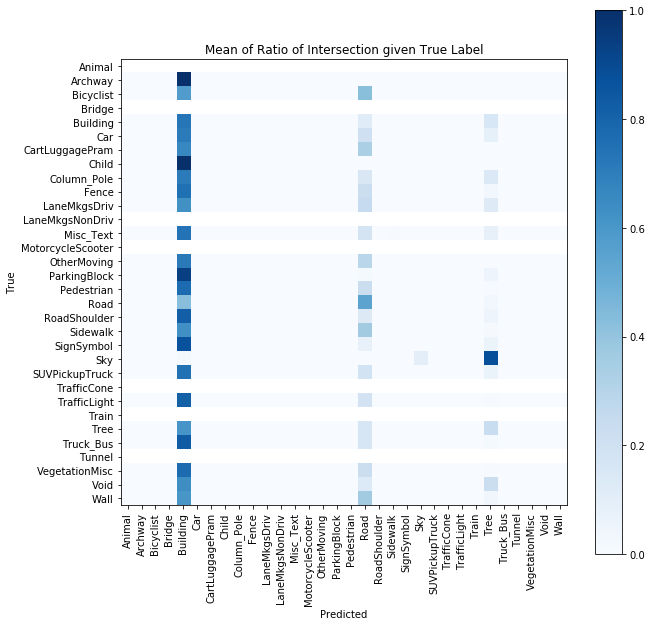

In [14]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

接下来让我们看看我们数据集中的单个最差预测。 看起来这个虚拟模型只是预测一切如道:)

label,score
Animal,nan
Road,0.00301489
Void,0
VegetationMisc,nan
Building,0.78254
Tunnel,nan
Truck_Bus,nan
Tree,0.366345
Train,nan
TrafficLight,nan


,label,score
0,Animal,nan
17,Road,0.00301489
30,Void,0
29,VegetationMisc,nan
4,Building,0.78254
28,Tunnel,nan
27,Truck_Bus,nan
26,Tree,0.366345
25,Train,nan
24,TrafficLight,nan


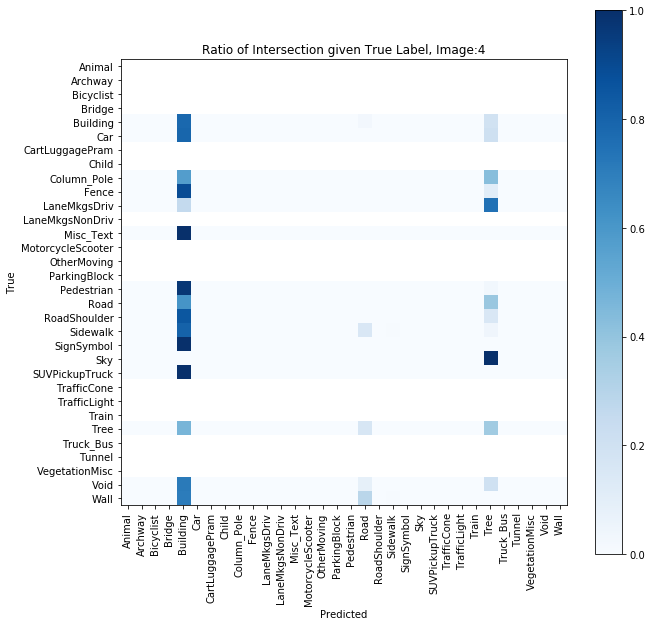

In [15]:
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

最后，我们将目测检查这一单一预测

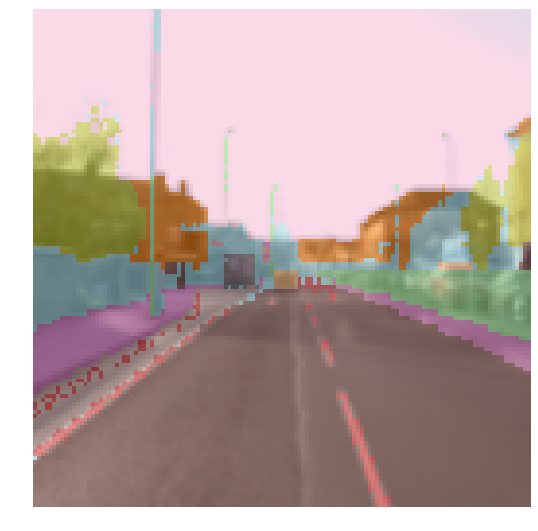

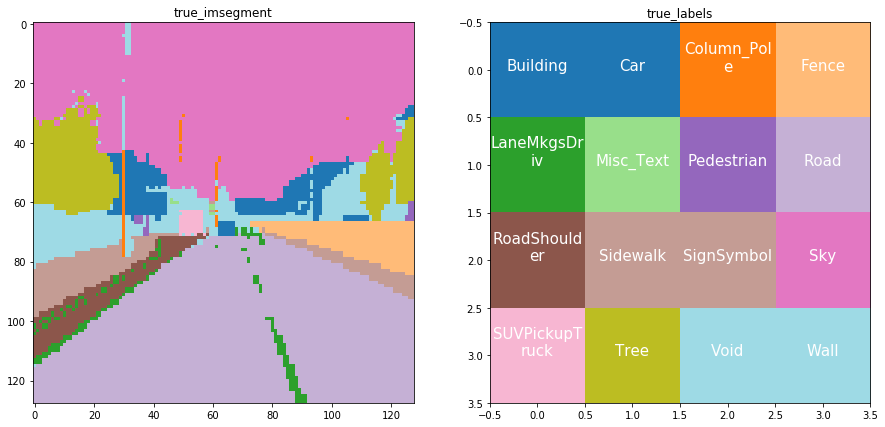

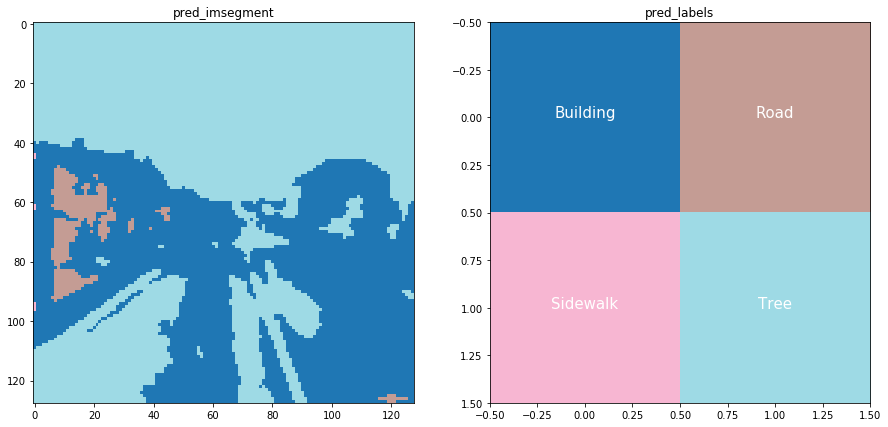

In [16]:
interp.show_xyz(i, sz=15)

`警告：使用matplotlib色彩图时，唯一定性颜色的最大数量为20.因此，如果len（类）> 20，则可以使用相同颜色绘制关闭类索引。 让我们一起解决这个问题:)`

```
{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}
```

**class ObjectDetectionInterpretation**

`ObjectDetectionInterpretation(learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=<DatasetType.Valid: 2>) :: Interpretation`

分类模型的解释方法。

`警告：尚未实现ObjectDetectionInterpretation。 随意实现它:)`